### Installing and importing the necessary libraries

In [ ]:
pip install pingouin

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 198.9/198.9 kB 2.7 MB/s eta 0:00:00


In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn import tree
from sklearn.svm import SVC
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.impute import KNNImputer
from xgboost import XGBClassifier
from pingouin import multivariate_normality
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, ExtraTreesClassifier, IsolationForest
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

### Installing the data

https://www.kaggle.com/datasets/johnsmith88/heart-disease-dataset

In [ ]:
data = pd.read_csv('/content/heart_disease_uci.csv', delimiter=',')
data = data.drop(data.columns[0], axis=1)
print(data)

     age     sex        dataset               cp  trestbps   chol    fbs  \
0     63    Male      Cleveland   typical angina     145.0  233.0   True   
1     67    Male      Cleveland     asymptomatic     160.0  286.0  False   
2     67    Male      Cleveland     asymptomatic     120.0  229.0  False   
3     37    Male      Cleveland      non-anginal     130.0  250.0  False   
4     41  Female      Cleveland  atypical angina     130.0  204.0  False   
..   ...     ...            ...              ...       ...    ...    ...   
915   54  Female  VA Long Beach     asymptomatic     127.0  333.0   True   
916   62    Male  VA Long Beach   typical angina       NaN  139.0  False   
917   55    Male  VA Long Beach     asymptomatic     122.0  223.0   True   
918   58    Male  VA Long Beach     asymptomatic       NaN  385.0   True   
919   62    Male  VA Long Beach  atypical angina     120.0  254.0  False   

              restecg  thalch  exang  oldpeak        slope   ca  \
0      lv hypertroph

# Data Preprocessing

## Data Transformation

In [ ]:
data.isnull().sum()

age           0
sex           0
dataset       0
cp            0
trestbps     59
chol         30
fbs          90
restecg       2
thalch       55
exang        55
oldpeak      62
slope       309
ca          611
thal        486
num           0
dtype: int64

There is a lot of null data. Later we are going to evaluate what technique to use to solve this problem.

In [ ]:
data.dtypes

age           int64
sex          object
dataset      object
cp           object
trestbps    float64
chol        float64
fbs          object
restecg      object
thalch      float64
exang        object
oldpeak     float64
slope        object
ca          float64
thal         object
num           int64
dtype: object

As the dataset used in this project is different than the one in the study

In [ ]:
categorical_cols = data.select_dtypes(include=['object']).columns.tolist()
continuous_cols  = data.select_dtypes(include=['int64','float64']).columns.tolist()

We need to transform the object type data to numerical type data in order to create the models we are going to compare. The transformations used are the same showed in the sistematic reviwe made by Ahsan et al.(2021)

In [ ]:
data['sex'].unique()

array(['Male', 'Female'], dtype=object)

In [ ]:
sex_replacing = {'Male': 1, 'Female': 0}
data['sex'] = data['sex'].replace(sex_replacing)

In [ ]:
#In the Sistematic Review, the column "dataset" isnt included in the attributes used, so, we are going to discard it
data = data.drop("dataset",axis = 1)

In [ ]:
data['cp'].unique()

array(['typical angina', 'asymptomatic', 'non-anginal', 'atypical angina'],
      dtype=object)

In [ ]:
chest_pain_replacing = {'typical angina': 1, 'non-anginal' : 3, 'atypical angina' : 2, 'asymptomatic': 4}
data['cp'] = data['cp'].replace(chest_pain_replacing)

In [ ]:
data['fbs'].unique()

array([True, False, nan], dtype=object)

In [ ]:
def convert_true_false_value(value):
    if value is True:
        return 1
    elif value is False:
        return 0
    else:
        return np.nan

In [ ]:
data['fbs'] = data['fbs'].apply(convert_true_false_value)

In [ ]:
data['restecg'].unique()

array(['lv hypertrophy', 'normal', 'st-t abnormality', nan], dtype=object)

In [ ]:
rest_elect_results = {'lv hypertrophy': 2, 'normal' : 0, 'st-t abnormality' : 1}
data['restecg'] = data['restecg'].replace(rest_elect_results)

In [ ]:
data['exang'].unique()

array([False, True, nan], dtype=object)

In [ ]:
data['exang'] = data['exang'].apply(convert_true_false_value)

In [ ]:
data['slope'].unique()

array(['downsloping', 'flat', 'upsloping', nan], dtype=object)

In [ ]:
slope_peak = {'downsloping': 3, 'flat' : 2, 'upsloping' : 1}
data['slope'] = data['slope'].replace(slope_peak)

In [ ]:
data['thal'].unique()

array(['fixed defect', 'normal', 'reversable defect', nan], dtype=object)

In [ ]:
type_defect = {'fixed defect': 6, 'normal' : 3, 'reversable defect' : 7}
data['thal'] = data['thal'].replace(type_defect)

In [ ]:
print(data)

     age  sex  cp  trestbps   chol  fbs  restecg  thalch  exang  oldpeak  \
0     63    1   1     145.0  233.0  1.0      2.0   150.0    0.0      2.3   
1     67    1   4     160.0  286.0  0.0      2.0   108.0    1.0      1.5   
2     67    1   4     120.0  229.0  0.0      2.0   129.0    1.0      2.6   
3     37    1   3     130.0  250.0  0.0      0.0   187.0    0.0      3.5   
4     41    0   2     130.0  204.0  0.0      2.0   172.0    0.0      1.4   
..   ...  ...  ..       ...    ...  ...      ...     ...    ...      ...   
915   54    0   4     127.0  333.0  1.0      1.0   154.0    0.0      0.0   
916   62    1   1       NaN  139.0  0.0      1.0     NaN    NaN      NaN   
917   55    1   4     122.0  223.0  1.0      1.0   100.0    0.0      0.0   
918   58    1   4       NaN  385.0  1.0      2.0     NaN    NaN      NaN   
919   62    1   2     120.0  254.0  0.0      2.0    93.0    1.0      0.0   

     slope   ca  thal  num  
0      3.0  0.0   6.0    0  
1      2.0  3.0   3.0    2  


In [ ]:
data.dtypes

age           int64
sex           int64
cp            int64
trestbps    float64
chol        float64
fbs         float64
restecg     float64
thalch      float64
exang       float64
oldpeak     float64
slope       float64
ca          float64
thal        float64
num           int64
dtype: object

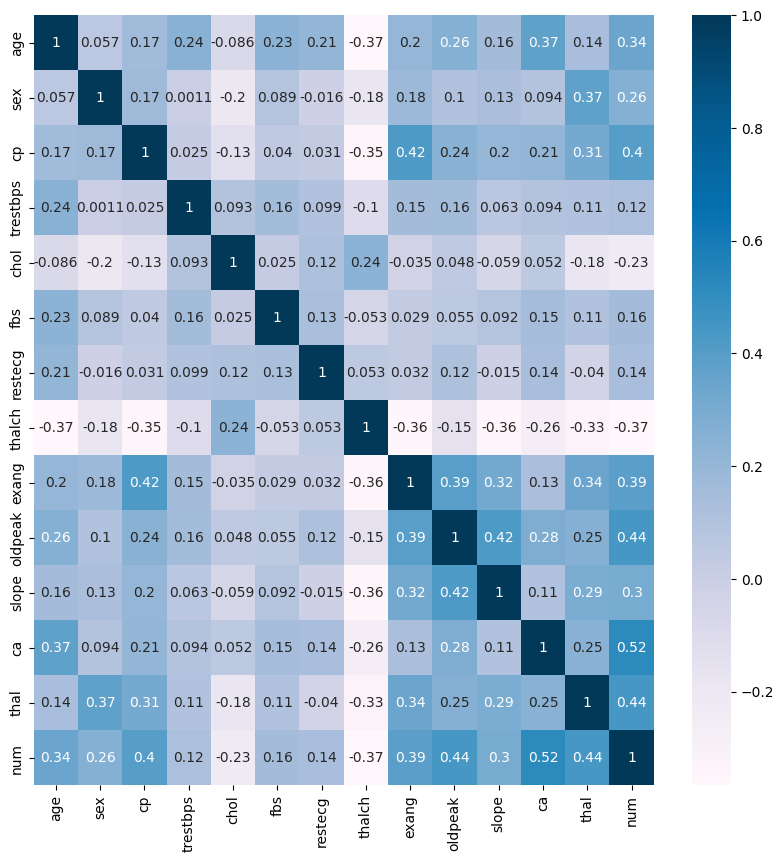

In [ ]:
plt.figure(figsize=(10,10))
cor = data.corr()
sns.heatmap(cor, annot=True, cmap=plt.cm.PuBu)
plt.show()

In [ ]:
#Function for the metrics
def calculate_metrics_clasification(y_test, predictions):
    '''
    y_test:- ground truth
    predictions:- model predict
    '''

    accuraccy = accuracy_score(y_test, predictions)
    precision = precision_score(y_test, predictions, average='macro')
    recall = recall_score(y_test, predictions, average='macro')
    f1 = f1_score(y_test, predictions, average='macro')

    print("Accuraccy Score: ", accuraccy)
    print("Precision Score: ", precision)
    print("Recall Score: ", recall)
    print("F1 Score: ", f1)

## Data Cleaning

In the phase of Data Transformation we can see there is not weird instances in the data, just missing values, which can create bias, making it harder to reach significant results and hinder the use of statistical methods like principal component analysis, clustering, regression analysis , etc..

Standard statistical strategies for dealing with missing data include deleting subjects with missing values, employing likelihood-based methods, data augmentation, and imputation (Austin et al., 2021; Tanner et al., 1987).

Because in this project we are using a different dataset compared to the one in the study (which has no null data), we are going to analyze the viability of many methods and techniques to these purpose , principally, we are going to analyze three of the most common methods, litwise deletion, simple imputation, Regression and KNN (K-Nearest Neighbors) imputation.

### Listwise Deletion Method

The Listwise Deletion Method is the most common method to handle missing data, consists in deleting all instances that have missing data. This implies that if a case lacks a value for any variable, it is completely removed from the analysis (Statistics Solutions, 2020).

The disavantage of this method is that can reduce the sample size significantly if several variables have missing values or a large number of missing values exist across the different variables. This loss of data can affect and weaken the the stasticial validity of the models and biased conclusions (Scheffer, 2002).

We can observe that the variables in the columns "slope", "ca" and "thal" have hundreds of missing values, so eliminating those is going to erase most of the data. Therefore, this method will be not used in this project.

### Simple Imputation methods

Simple Imputation methods consist of replace the missing value pf the mean, median or the mode.However, this strategy reduces the variability of the data or necessitates parametric assumptions about the data, such as normality (Van Buuren et al., 2000).

Therefore, we are going to apply a normality test to our data set in order to analyze if it is viable or not to use Mean/Median/Mode Imputation method to manage our null data.

The normal distribution illustrates how things can happen by chance. In other words, there are events or occurrences that can happen more frequently than others. In the middle is the most common value, known as the average. As you move away from the average, occurrences become less frequent and more predictable (Burkardt, 2014).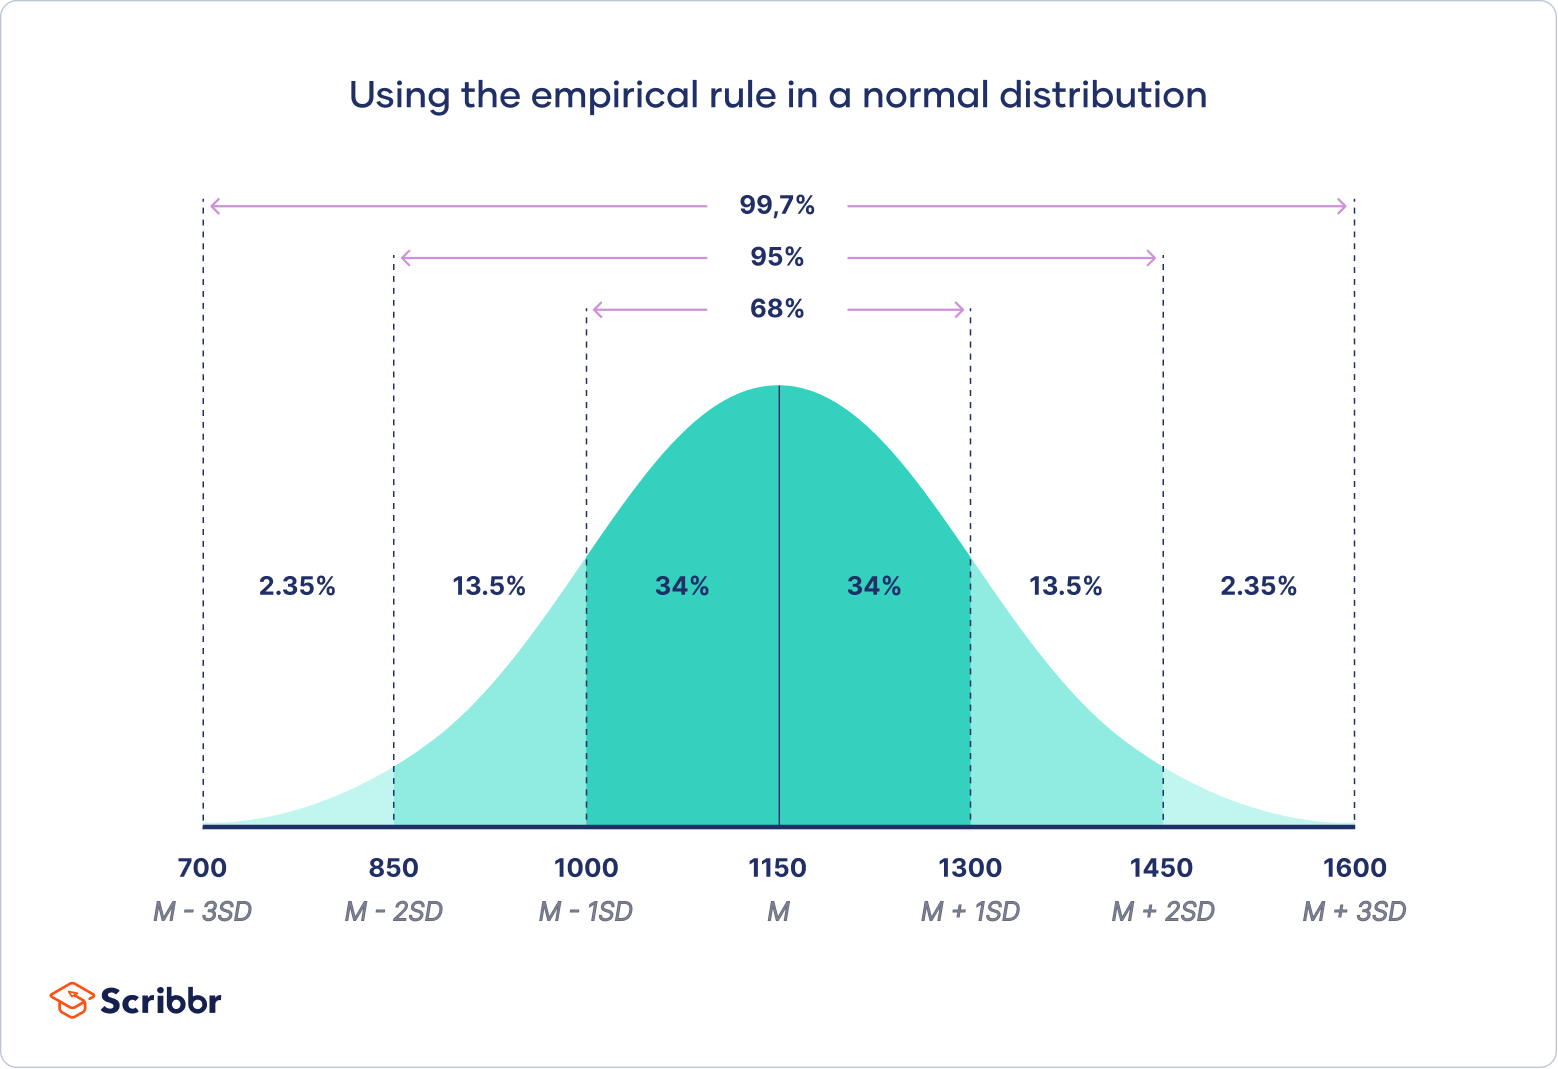

Taking into account that our data set is multivariate, using univariate normality tests such as Shapiro-Wilk is not totally appropriate, therefore, the Henze-Zirkler test seems more appropiate, which is a statistical test that determines the multivariate normality of a data set. It uses a random data sample and is one of the most consistent methods for assessing the normality of multivariate data sets (Flegel & Bennett, 2020).

In [ ]:
multivariate_normality(data, alpha=0.05)

HZResults(hz=1.2372718463601735, pval=0.0, normal=False)

*   H0 (Null Hypothesis): The variables follow a multivariate normal distribution

*   H0 (Null Hypothesis): The variables follow a multivariate normal distribution

With a confidence level of 95%, there is sufficient statistical evidence to reject the null hypothesis, therefore, it can be stated that the data probably do not follow a normal distribution. So, it is not appropriate to apply data imputation methods (or any other methods for another purpose) that require that the data follow an approximation of a normal distribution.

### Regression based methods

Regression-based approaches are a sophisticated method that employ information from several variables to fill in missing data by predicting missing values based on previously observed values. Essentially, they build a prediction model to anticipate what the missing numbers should be based on patterns observed in current data (Little et al., 1989). However, regression imputation is a preferred method to use when more than 5% of the data is missing (Rubin et al., 2007). Therefore, for this project, this method would be also not included because the missing data is a lot more that 5% of the total data.



### KNN (K-Nearest Neighbors) Imputation

The KNN imputation technique is one of the most popular because it is simple and at the same time effective in filling in missing information in a data set. This approach attempts to find the K closest subjects and fills the missing data with the weighted average value of the observed values ​​of these neighbors (Liao et al., 2014).

The biggest disadvantage of this imputation method is that it searches for the instances with the greatest similarity and to do so, the algorithm must search the entire data set. This disadvantage affects especially when used on a huge data set (García et al. , 2008).

Despite this disavantage,iIn the Systematic Review carried out by Ismail et al. (2022) it was found that KNN is the most used algorithm for the purpose of imputation of missing values. With the ability to handle any type and scale of data, in addition to efficiently processing any data set, regardless of sample size. Additionally, it outperformed other imputation methods, such as support vector machine, naïve Bayes, decision tree, and self-organizing maps (SOM).

From the above it follows that KNN will be the missing data handling method that will be used for this project.

#### Aplication of KNN Imputation method

In [ ]:
categorical_cols.remove('dataset')
data_categorical = data[categorical_cols]
data_continuous = data[continuous_cols]

In [ ]:
def impute_categorical_knn(data):
    knn_imputer = KNNImputer(n_neighbors=5)
    imputed = knn_imputer.fit_transform(data_categorical)
    imputed_rounded = np.round(imputed)
    return pd.DataFrame(imputed_rounded, columns=data_categorical.columns)

In [ ]:
df_categorical_imputed = impute_categorical_knn(data_categorical)
knn_imputer_continuous = KNNImputer(n_neighbors=5)
data_continuous_imputed = pd.DataFrame(knn_imputer_continuous.fit_transform(data_continuous), columns=continuous_cols)
df_imputed = pd.concat([df_categorical_imputed, data_continuous_imputed], axis=1)


In [ ]:
print(df_imputed)

     sex   cp  fbs  restecg  exang  slope  thal   age  trestbps   chol  \
0    1.0  1.0  1.0      2.0    0.0    3.0   6.0  63.0     145.0  233.0   
1    1.0  4.0  0.0      2.0    1.0    2.0   3.0  67.0     160.0  286.0   
2    1.0  4.0  0.0      2.0    1.0    2.0   7.0  67.0     120.0  229.0   
3    1.0  3.0  0.0      0.0    0.0    3.0   3.0  37.0     130.0  250.0   
4    0.0  2.0  0.0      2.0    0.0    1.0   3.0  41.0     130.0  204.0   
..   ...  ...  ...      ...    ...    ...   ...   ...       ...    ...   
915  0.0  4.0  1.0      1.0    0.0    2.0   6.0  54.0     127.0  333.0   
916  1.0  1.0  0.0      1.0    0.0    1.0   5.0  62.0     132.8  139.0   
917  1.0  4.0  1.0      1.0    0.0    1.0   6.0  55.0     122.0  223.0   
918  1.0  4.0  1.0      2.0    1.0    2.0   6.0  58.0     138.8  385.0   
919  1.0  2.0  0.0      2.0    1.0    1.0   5.0  62.0     120.0  254.0   

     thalch  oldpeak   ca  num  
0     150.0      2.3  0.0  0.0  
1     108.0      1.5  3.0  2.0  
2     129.0 

In [ ]:
df_imputed.isnull().sum()

sex         0
cp          0
fbs         0
restecg     0
exang       0
slope       0
thal        0
age         0
trestbps    0
chol        0
thalch      0
oldpeak     0
ca          0
num         0
dtype: int64

### Outlier detection

In order to detect outlier data, there were created many methods such as density-based (such as Local Outlier Factory (LOF)) , distance-based (such as K-means and k-Nearest Neighbors (k-NN)) , neural network, and spectral-based. But those methods were orignillay developed for machine learning purposes such as classificacation or clustering and later were modified for detection of outlier data (Chandola et al. ,2009).


#### Isolation Forest (IF)

The  Isolation Forest (IF) algorithm was one of many specially developed outlier detection. This method is based on the simple principle that data outliers or data anomalies are easy to isolate and detect because the minority of the instances of a dataset and their attribute-values are different from the rest of the instances. (Liu et al. ,2008).

One of the advantages of IF is that it has significantly less execution time than other methods because it does not need to compute any distance or density (Chabchoub et al. , 2022). Further more, it has capacity to handle extremely large and high-dimensional data and, unlike other methods, where large sampling size is more appropriate,  the sample size necessary to best performance is better to keep it small (Yousra et al. ,2022).

This method is divided into two stages: the training phase;  the creation of the forest, and the scoring phase; generation a score for each instance in the dataset.


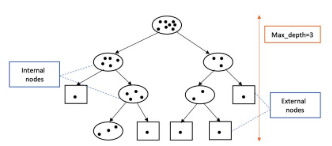

[Image of a binary tree with a maximum depth of 3 and internal and external nodes]. Chabchoub et al. (2022). An in-depth study and improvement of Isolation Forest. IEEE Access, 10, 10219-10237.


In the systematic review made by Al Farizi et al. (2021) it was show that IF surpasses other methods of ouliers detectetion, in terms of accuracy and speed, while also demonstrating good performance with high-dimensional datasets. Because of this, in this project, for the purpose of anomaly or outlier data detection, we will be using Isolation Forest method.

#### Isolation Forest (EIF)

In [ ]:
#Create the list of the Predective Variables

predictive_variables = df_imputed.columns.tolist()
predictive_variables.remove('num')
predictive_variables = pd.Index(predictive_variables)

##### Training Phase

In the training phase, the data is divided by binary trees (Ithees) until the tree archieved an specific height or until is no longer possible to divide the data. The normal data will go deeper and deeper into the Itree and anomaly points will not go as deep.

In [ ]:
IF = IsolationForest(contamination=0.1)
IF.fit(df_imputed[predictive_variables])

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(


IsolationForest(contamination=0.1)

##### Scoring Phase

In this phase, for each instance of the dataset is calculated a score that represents how similiar are each instance from the other ones. An score of 0.5 of less is treated as normal data, by contrast, an score superior to 0.5 to 1, is considered an outlier.


In [ ]:
df_imputed['anomaly_scores'] = IF.decision_function(df_imputed[predictive_variables])
df_imputed['anomaly'] = IF.predict(df_imputed[predictive_variables])
df_imputed

,sex,cp,fbs,restecg,exang,slope,thal,age,trestbps,chol,thalch,oldpeak,ca,num,anomaly_scores,anomaly
0,1.0,1.0,1.0,2.0,0.0,3.0,6.0,63.0,145.0,233.0,150.0,2.3,0.0,0.0,-0.061841,-1
1,1.0,4.0,0.0,2.0,1.0,2.0,3.0,67.0,160.0,286.0,108.0,1.5,3.0,2.0,-0.005506,-1
2,1.0,4.0,0.0,2.0,1.0,2.0,7.0,67.0,120.0,229.0,129.0,2.6,2.0,1.0,0.077810,1
3,1.0,3.0,0.0,0.0,0.0,3.0,3.0,37.0,130.0,250.0,187.0,3.5,0.0,0.0,-0.016023,-1
4,0.0,2.0,0.0,2.0,0.0,1.0,3.0,41.0,130.0,204.0,172.0,1.4,0.0,0.0,0.015538,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
915,0.0,4.0,1.0,1.0,0.0,2.0,6.0,54.0,127.0,333.0,154.0,0.0,0.6,1.0,-0.001017,-1
916,1.0,1.0,0.0,1.0,0.0,1.0,5.0,62.0,132.8,139.0,118.0,0.4,1.0,0.0,0.032562,1
917,1.0,4.0,1.0,1.0,0.0,1.0,6.0,55.0,122.0,223.0,100.0,0.0,0.2,2.0,0.028816,1
918,1.0,4.0,1.0,2.0,1.0,2.0,6.0,58.0,138.8,385.0,123.6,0.6,1.0,0.0,0.037346,1


In [ ]:
print (df_imputed["anomaly"].value_counts())

anomaly
 1    828
-1     92
Name: count, dtype: int64


In [ ]:
#As the quantity of outlier Data isn't significant, the consenquences of erase it will be minimum, so, we are going to remove it.
threshold = 0.5

df_cleaned = df_imputed[df_imputed['anomaly'] == 1]
df_cleaned = df_cleaned[df_cleaned['anomaly_scores'] < threshold]

#### Data Balacing

In [ ]:
print(df_cleaned["num"].value_counts(normalize=True) * 100)
print (df_cleaned["num"].value_counts())

num
0.0    45.169082
1.0    29.951691
2.0    11.473430
3.0    10.990338
4.0     2.415459
Name: proportion, dtype: float64
num
0.0    374
1.0    248
2.0     95
3.0     91
4.0     20
Name: count, dtype: int64


0 = absence.
1, 2, 3, 4 = present.
The dataset has 509 instances with the disease present a 411 without it, so apparently, there isnt an imbalance of classes. So in this project isnt neccesarry to apply any balacing data technique.

# Modeling the Data:

### Without Data Standarization (WS):

In [ ]:
df = df_cleaned
X = df_imputed.drop("num",axis = 1)
y = df_imputed["num"]
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size= 0.3, random_state=42)


#### Logistic Regression (LS)

In [ ]:
logisticRegr = LogisticRegression()
logisticRegr.fit(X_train, y_train)
predictions = logisticRegr.predict(X_test)
calculate_metrics_clasification(y_test, predictions)

Accuraccy Score:  0.5434782608695652
Precision Score:  0.30182072829131656
Recall Score:  0.3098290598290598
F1 Score:  0.286883378888455


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


#### Linear Discriminant Analysis (LDA)

In [ ]:
lda = LinearDiscriminantAnalysis()
lda.fit(X_train, y_train)
predictions = lda.predict(X_test)
calculate_metrics_clasification(y_test, predictions)

Accuraccy Score:  0.5652173913043478
Precision Score:  0.3655283582980814
Recall Score:  0.35855706385118147
F1 Score:  0.35169264598553684


#### K-Nearest Neighbors (KNN):

In [ ]:
knn = KNeighborsClassifier()
knn.fit(X_train, y_train)
predictions = knn.predict(X_test)
calculate_metrics_clasification(y_test, predictions)

Accuraccy Score:  0.4528985507246377
Precision Score:  0.2369648290130218
Recall Score:  0.24545500251382601
F1 Score:  0.22696512742279334


#### Naïve Bayes (NB)

In [ ]:
nb = GaussianNB()
nb.fit(X_train, y_train)
predictions = nb.predict(X_test)
calculate_metrics_clasification(y_test, predictions)

Accuraccy Score:  0.532608695652174
Precision Score:  0.3366967526188413
Recall Score:  0.3356963298139769
F1 Score:  0.3223442495573643


#### Support Vector Machine (SVM)

In [ ]:
svc = SVC()
svc.fit(X_train, y_train)
predictions = svc.predict(X_test)
calculate_metrics_clasification(y_test, predictions)

Accuraccy Score:  0.4782608695652174
Precision Score:  0.16601319334757966
Recall Score:  0.23346153846153847
F1 Score:  0.1820974212034384


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


#### XGBoost Algorithm (XGB)

In [ ]:
xgb = XGBClassifier()
xgb.fit(X_train, y_train)
predictions = xgb.predict(X_test)
calculate_metrics_clasification(y_test, predictions)

Accuraccy Score:  0.5942028985507246
Precision Score:  0.38930591684214877
Recall Score:  0.38306938159879333
F1 Score:  0.3830162613341241


#### Decision Tree Classifier (DT)

In [ ]:
tree = DecisionTreeClassifier()
tree.fit(X_train, y_train)
predictions = tree.predict(X_test)
calculate_metrics_clasification(y_test, predictions)

Accuraccy Score:  0.5108695652173914
Precision Score:  0.35612765085586084
Recall Score:  0.34432629462041225
F1 Score:  0.3462347489658425


#### Random Forest Classifier (RF)

In [ ]:
forest = RandomForestClassifier()
forest.fit(X_train, y_train)
predictions = forest.predict(X_test)
calculate_metrics_clasification(y_test, predictions)

Accuraccy Score:  0.5471014492753623
Precision Score:  0.3143552546744036
Recall Score:  0.32055304172951227
F1 Score:  0.3088668462938139


#### Gradient Boost (GB)

In [ ]:
gb = GradientBoostingClassifier()
gb.fit(X_train, y_train)
predictions = gb.predict(X_test)
calculate_metrics_clasification(y_test, predictions)

Accuraccy Score:  0.5797101449275363
Precision Score:  0.41965240641711227
Recall Score:  0.3877425842131724
F1 Score:  0.39490509451599504


#### AdaBoost (AB)

In [ ]:
ab = AdaBoostClassifier()
ab.fit(X_train, y_train)
predictions = ab.predict(X_test)
calculate_metrics_clasification(y_test, predictions)

Accuraccy Score:  0.5036231884057971
Precision Score:  0.31895926777793854
Recall Score:  0.3194268476621418
F1 Score:  0.3168689712502942


#### Extra Tree classifier (ET)

In [ ]:
et = ExtraTreesClassifier()
et.fit(X_train, y_train)
predictions = et.predict(X_test)
calculate_metrics_clasification(y_test, predictions)

Accuraccy Score:  0.5543478260869565
Precision Score:  0.3782889822595705
Recall Score:  0.3523328305681247
F1 Score:  0.35282390468148983


### With Data Standarization (S):

### Standscale (SS):

In [ ]:
from sklearn.preprocessing import StandardScaler


#### Logistic Regression (LS)

In [ ]:
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('log_reg', LogisticRegression())
])

pipeline.fit(X_train, y_train)
predictions = pipeline.predict(X_test)
calculate_metrics_clasification(y_test, predictions)

Accuraccy Score:  0.5543478260869565
Precision Score:  0.3714960564549606
Recall Score:  0.34898692810457516
F1 Score:  0.3462608707561253


#### Linear Discriminant Analysis (LDA)

In [ ]:
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('lda', LinearDiscriminantAnalysis())
])
pipeline.fit(X_train, y_train)
predictions = pipeline.predict(X_test)
calculate_metrics_clasification(y_test, predictions)

Accuraccy Score:  0.5543478260869565
Precision Score:  0.34248300368559387
Recall Score:  0.34422825540472596
F1 Score:  0.33377877587816734


#### K-Nearest Neighbors (KNN):

In [ ]:
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('knn', KNeighborsClassifier())
])
pipeline.fit(X_train, y_train)
predictions = pipeline.predict(X_test)
calculate_metrics_clasification(y_test, predictions)

Accuraccy Score:  0.5507246376811594
Precision Score:  0.3685739348370928
Recall Score:  0.3388109602815485
F1 Score:  0.33626343192644287


#### Naïve Bayes (NB)

In [ ]:
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('nb', GaussianNB())
])
pipeline.fit(X_train, y_train)
predictions = pipeline.predict(X_test)
calculate_metrics_clasification(y_test, predictions)

Accuraccy Score:  0.5217391304347826
Precision Score:  0.32485486017544507
Recall Score:  0.3283308195072901
F1 Score:  0.31774225774225784


#### Support Vector Machine (SVM)

In [ ]:
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('svc', SVC())
])
pipeline.fit(X_train, y_train)
predictions = pipeline.predict(X_test)
calculate_metrics_clasification(y_test, predictions)

Accuraccy Score:  0.5181159420289855
Precision Score:  0.2785402759234535
Recall Score:  0.2910105580693816
F1 Score:  0.2687506373750792


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


#### XGBoost Algorithm (XGB)

In [ ]:
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('xgb', XGBClassifier())
])
pipeline.fit(X_train, y_train)
predictions = pipeline.predict(X_test)
calculate_metrics_clasification(y_test, predictions)

Accuraccy Score:  0.5797101449275363
Precision Score:  0.37099988413857027
Recall Score:  0.3589969834087481
F1 Score:  0.3570091271465208


#### Decision Tree Classifier (DT)

In [ ]:
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('dt', DecisionTreeClassifier())
])
pipeline.fit(X_train, y_train)
predictions = pipeline.predict(X_test)
calculate_metrics_clasification(y_test, predictions)

Accuraccy Score:  0.5144927536231884
Precision Score:  0.3355019898580058
Recall Score:  0.33228758169934636
F1 Score:  0.33303621147992263


#### Random Forest Classifier (RF)

In [ ]:
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('rf', RandomForestClassifier())
])
pipeline.fit(X_train, y_train)
predictions = pipeline.predict(X_test)
calculate_metrics_clasification(y_test, predictions)

Accuraccy Score:  0.5543478260869565
Precision Score:  0.33511202233702464
Recall Score:  0.33199095022624436
F1 Score:  0.3244903937559188


#### Gradient Boost (GB)

In [ ]:
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('gb', GradientBoostingClassifier())
])
pipeline.fit(X_train, y_train)
predictions = pipeline.predict(X_test)
calculate_metrics_clasification(y_test, predictions)

Accuraccy Score:  0.572463768115942
Precision Score:  0.34075772489529654
Recall Score:  0.34124937154348917
F1 Score:  0.33172740222659924


#### AdaBoost (AB)

In [ ]:
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('ab', AdaBoostClassifier())
])
pipeline.fit(X_train, y_train)
predictions = pipeline.predict(X_test)
calculate_metrics_clasification(y_test, predictions)

Accuraccy Score:  0.5108695652173914
Precision Score:  0.31435608902225554
Recall Score:  0.31384112619406734
F1 Score:  0.31084624913825265


#### Extra Tree classifier (ET)

In [ ]:
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('et', ExtraTreesClassifier())
])
pipeline.fit(X_train, y_train)
predictions = pipeline.predict(X_test)
calculate_metrics_clasification(y_test, predictions)

Accuraccy Score:  0.5398550724637681
Precision Score:  0.30748556998557
Recall Score:  0.3189869281045752
F1 Score:  0.3074228733114275


### MinMax (MM):

In [ ]:
from sklearn.preprocessing import MinMaxScaler


#### Logistic Regression (LC)

In [ ]:
pipeline = Pipeline([
    ('scaler', MinMaxScaler()),
    ('log_reg', LogisticRegression())
])

pipeline.fit(X_train, y_train)
predictions = pipeline.predict(X_test)
calculate_metrics_clasification(y_test, predictions)

Accuraccy Score:  0.5507246376811594
Precision Score:  0.3117823706059
Recall Score:  0.3146857717445952
F1 Score:  0.29707522578625345


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


#### Linear Discriminant Analysis (LDA)

In [ ]:
pipeline = Pipeline([
    ('scaler', MinMaxScaler()),
    ('lda', LinearDiscriminantAnalysis())
])
pipeline.fit(X_train, y_train)
predictions = pipeline.predict(X_test)
calculate_metrics_clasification(y_test, predictions)

Accuraccy Score:  0.5543478260869565
Precision Score:  0.34248300368559387
Recall Score:  0.34422825540472596
F1 Score:  0.33377877587816734


#### K-Nearest Neighbors (KNN):

In [ ]:
pipeline = Pipeline([
    ('scaler', MinMaxScaler()),
    ('knn', KNeighborsClassifier())
])
pipeline.fit(X_train, y_train)
predictions = pipeline.predict(X_test)
calculate_metrics_clasification(y_test, predictions)

Accuraccy Score:  0.5833333333333334
Precision Score:  0.4019508448540707
Recall Score:  0.3675439919557566
F1 Score:  0.3690964344297677


#### Naïve Bayes (NB)

In [ ]:
pipeline = Pipeline([
    ('scaler', MinMaxScaler()),
    ('nb', GaussianNB())
])
pipeline.fit(X_train, y_train)
predictions = pipeline.predict(X_test)
calculate_metrics_clasification(y_test, predictions)

Accuraccy Score:  0.5217391304347826
Precision Score:  0.32485486017544507
Recall Score:  0.3283308195072901
F1 Score:  0.31774225774225784


#### Support Vector Machine (SVM)

In [ ]:
pipeline = Pipeline([
    ('scaler', MinMaxScaler()),
    ('svc', SVC())
])
pipeline.fit(X_train, y_train)
predictions = pipeline.predict(X_test)
calculate_metrics_clasification(y_test, predictions)

Accuraccy Score:  0.5289855072463768
Precision Score:  0.20722128378378377
Recall Score:  0.28551282051282045
F1 Score:  0.2390233299521808


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


#### XGBoost Algorithm (XGB)

In [ ]:
pipeline = Pipeline([
    ('scaler', MinMaxScaler()),
    ('xgb', XGBClassifier())
])
pipeline.fit(X_train, y_train)
predictions = pipeline.predict(X_test)
calculate_metrics_clasification(y_test, predictions)

Accuraccy Score:  0.5797101449275363
Precision Score:  0.37099988413857027
Recall Score:  0.3589969834087481
F1 Score:  0.3570091271465208


#### Decision Tree Classifier (DT)

In [ ]:
pipeline = Pipeline([
    ('scaler', MinMaxScaler()),
    ('dt', DecisionTreeClassifier())
])
pipeline.fit(X_train, y_train)
predictions = pipeline.predict(X_test)
calculate_metrics_clasification(y_test, predictions)

Accuraccy Score:  0.5108695652173914
Precision Score:  0.3383745017602048
Recall Score:  0.3395123177476119
F1 Score:  0.33765475116434496


#### Random Forest Classifier (RF)

In [ ]:
pipeline = Pipeline([
    ('scaler', MinMaxScaler()),
    ('rf', RandomForestClassifier())
])
pipeline.fit(X_train, y_train)
predictions = pipeline.predict(X_test)
calculate_metrics_clasification(y_test, predictions)

Accuraccy Score:  0.5615942028985508
Precision Score:  0.35621417106168307
Recall Score:  0.3422046254399196
F1 Score:  0.3382558502155948


#### Gradient Boost (GB)

In [ ]:
pipeline = Pipeline([
    ('scaler', MinMaxScaler()),
    ('gb', GradientBoostingClassifier())
])
pipeline.fit(X_train, y_train)
predictions = pipeline.predict(X_test)
calculate_metrics_clasification(y_test, predictions)

Accuraccy Score:  0.5760869565217391
Precision Score:  0.3534705882352941
Recall Score:  0.34713172448466567
F1 Score:  0.3395219617305291


#### AdaBoost (AB)

In [ ]:
pipeline = Pipeline([
    ('scaler', MinMaxScaler()),
    ('ab', AdaBoostClassifier())
])
pipeline.fit(X_train, y_train)
predictions = pipeline.predict(X_test)
calculate_metrics_clasification(y_test, predictions)

Accuraccy Score:  0.5108695652173914
Precision Score:  0.31435608902225554
Recall Score:  0.31384112619406734
F1 Score:  0.31084624913825265


#### Extra Tree classifier (ET)

In [ ]:
pipeline = Pipeline([
    ('scaler', MinMaxScaler()),
    ('et', ExtraTreesClassifier())
])
pipeline.fit(X_train, y_train)
predictions = pipeline.predict(X_test)
calculate_metrics_clasification(y_test, predictions)

Accuraccy Score:  0.5471014492753623
Precision Score:  0.33486332109343125
Recall Score:  0.330507792860734
F1 Score:  0.32584473357598076


### MaxAbs (MA):

In [ ]:
from sklearn.preprocessing import MaxAbsScaler


#### Logistic Regression:

In [ ]:
pipeline = Pipeline([
    ('scaler', MaxAbsScaler()),
    ('log_reg', LogisticRegression())
])

pipeline.fit(X_train, y_train)
predictions = pipeline.predict(X_test)
calculate_metrics_clasification(y_test, predictions)

Accuraccy Score:  0.5579710144927537
Precision Score:  0.32721410711935783
Recall Score:  0.32190799396681746
F1 Score:  0.3047501811975404


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


#### Linear Discriminant Analysis (LDA)

In [ ]:
pipeline = Pipeline([
    ('scaler', MaxAbsScaler()),
    ('lda', LinearDiscriminantAnalysis())
])
pipeline.fit(X_train, y_train)
predictions = pipeline.predict(X_test)
calculate_metrics_clasification(y_test, predictions)

Accuraccy Score:  0.5543478260869565
Precision Score:  0.34248300368559387
Recall Score:  0.34422825540472596
F1 Score:  0.33377877587816734


#### K-Nearest Neighbors (KNN):

In [ ]:
pipeline = Pipeline([
    ('scaler', MaxAbsScaler()),
    ('knn', KNeighborsClassifier())
])
pipeline.fit(X_train, y_train)
predictions = pipeline.predict(X_test)
calculate_metrics_clasification(y_test, predictions)

Accuraccy Score:  0.5833333333333334
Precision Score:  0.3901143790849673
Recall Score:  0.3603368526897939
F1 Score:  0.3584050487664946


#### Naïve Bayes (NB)

In [ ]:
pipeline = Pipeline([
    ('scaler', MaxAbsScaler()),
    ('nb', GaussianNB())
])
pipeline.fit(X_train, y_train)
predictions = pipeline.predict(X_test)
calculate_metrics_clasification(y_test, predictions)

Accuraccy Score:  0.5217391304347826
Precision Score:  0.32485486017544507
Recall Score:  0.3283308195072901
F1 Score:  0.31774225774225784


#### Support Vector Machine (SVM)

In [ ]:
pipeline = Pipeline([
    ('scaler', MaxAbsScaler()),
    ('svc', SVC())
])
pipeline.fit(X_train, y_train)
predictions = pipeline.predict(X_test)
calculate_metrics_clasification(y_test, predictions)

Accuraccy Score:  0.5217391304347826
Precision Score:  0.20509682911257715
Recall Score:  0.28217948717948715
F1 Score:  0.2364834364761558


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


#### XGBoost Algorithm (XGB)

In [ ]:
pipeline = Pipeline([
    ('scaler', MaxAbsScaler()),
    ('xgb', XGBClassifier())
])
pipeline.fit(X_train, y_train)
predictions = pipeline.predict(X_test)
calculate_metrics_clasification(y_test, predictions)

Accuraccy Score:  0.5797101449275363
Precision Score:  0.37099988413857027
Recall Score:  0.3589969834087481
F1 Score:  0.3570091271465208


#### Decision Tree Classifier (DT)

In [ ]:
pipeline = Pipeline([
    ('scaler', MaxAbsScaler()),
    ('dt', DecisionTreeClassifier())
])
pipeline.fit(X_train, y_train)
predictions = pipeline.predict(X_test)
calculate_metrics_clasification(y_test, predictions)

Accuraccy Score:  0.4963768115942029
Precision Score:  0.3452821795350315
Recall Score:  0.3391553544494721
F1 Score:  0.34118714390179994


#### Random Forest Classifier (RF)

In [ ]:
pipeline = Pipeline([
    ('scaler', MaxAbsScaler()),
    ('rf', RandomForestClassifier())
])
pipeline.fit(X_train, y_train)
predictions = pipeline.predict(X_test)
calculate_metrics_clasification(y_test, predictions)

Accuraccy Score:  0.5579710144927537
Precision Score:  0.34962502268970985
Recall Score:  0.34238813474107593
F1 Score:  0.33895195077245355


#### Gradient Boost (GB)

In [ ]:
pipeline = Pipeline([
    ('scaler', MaxAbsScaler()),
    ('gb', GradientBoostingClassifier())
])
pipeline.fit(X_train, y_train)
predictions = pipeline.predict(X_test)
calculate_metrics_clasification(y_test, predictions)

Accuraccy Score:  0.5652173913043478
Precision Score:  0.3265681720597994
Recall Score:  0.333129713423831
F1 Score:  0.3216847457719291


#### AdaBoost (AB)

In [ ]:
pipeline = Pipeline([
    ('scaler', MaxAbsScaler()),
    ('ab', AdaBoostClassifier())
])
pipeline.fit(X_train, y_train)
predictions = pipeline.predict(X_test)
calculate_metrics_clasification(y_test, predictions)

Accuraccy Score:  0.5108695652173914
Precision Score:  0.31435608902225554
Recall Score:  0.31384112619406734
F1 Score:  0.31084624913825265


#### Extra Tree classifier (ET)

In [ ]:
pipeline = Pipeline([
    ('scaler', MaxAbsScaler()),
    ('et', ExtraTreesClassifier())
])
pipeline.fit(X_train, y_train)
predictions = pipeline.predict(X_test)
calculate_metrics_clasification(y_test, predictions)

Accuraccy Score:  0.5579710144927537
Precision Score:  0.3532112241751465
Recall Score:  0.33634992458521873
F1 Score:  0.3314912120760055


### Robust Scaler (RS):

In [ ]:
from sklearn.preprocessing import RobustScaler


#### Logistic Regression:

In [ ]:
pipeline = Pipeline([
    ('scaler', RobustScaler()),
    ('log_reg', LogisticRegression())
])

pipeline.fit(X_train, y_train)
predictions = pipeline.predict(X_test)
calculate_metrics_clasification(y_test, predictions)

Accuraccy Score:  0.572463768115942
Precision Score:  0.4192831541218638
Recall Score:  0.37176219205630967
F1 Score:  0.37763185018824114


#### Linear Discriminant Analysis (LDA)

In [ ]:
pipeline = Pipeline([
    ('scaler', RobustScaler()),
    ('lda', LinearDiscriminantAnalysis())
])
pipeline.fit(X_train, y_train)
predictions = pipeline.predict(X_test)
calculate_metrics_clasification(y_test, predictions)

Accuraccy Score:  0.5652173913043478
Precision Score:  0.3655283582980814
Recall Score:  0.35855706385118147
F1 Score:  0.35169264598553684


#### K-Nearest Neighbors (KNN):

In [ ]:
pipeline = Pipeline([
    ('scaler', RobustScaler()),
    ('knn', KNeighborsClassifier())
])
pipeline.fit(X_train, y_train)
predictions = pipeline.predict(X_test)
calculate_metrics_clasification(y_test, predictions)

Accuraccy Score:  0.5543478260869565
Precision Score:  0.331952467403862
Recall Score:  0.3320462543991956
F1 Score:  0.32522078936154036


#### Naïve Bayes (NB)

In [ ]:
pipeline = Pipeline([
    ('scaler', RobustScaler()),
    ('nb', GaussianNB())
])
pipeline.fit(X_train, y_train)
predictions = pipeline.predict(X_test)
calculate_metrics_clasification(y_test, predictions)

Accuraccy Score:  0.532608695652174
Precision Score:  0.3366967526188413
Recall Score:  0.3356963298139769
F1 Score:  0.3223442495573643


#### Support Vector Machine (SVM)

In [ ]:
pipeline = Pipeline([
    ('scaler', RobustScaler()),
    ('svc', SVC())
])
pipeline.fit(X_train, y_train)
predictions = pipeline.predict(X_test)
calculate_metrics_clasification(y_test, predictions)

Accuraccy Score:  0.5471014492753623
Precision Score:  0.29709241952232607
Recall Score:  0.3127199597787833
F1 Score:  0.29104616732523714


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


#### XGBoost Algorithm (XGB)

In [ ]:
pipeline = Pipeline([
    ('scaler', RobustScaler()),
    ('xgb', XGBClassifier())
])
pipeline.fit(X_train, y_train)
predictions = pipeline.predict(X_test)
calculate_metrics_clasification(y_test, predictions)

Accuraccy Score:  0.5942028985507246
Precision Score:  0.38930591684214877
Recall Score:  0.38306938159879333
F1 Score:  0.3830162613341241


#### Decision Tree Classifier (DT)

In [ ]:
pipeline = Pipeline([
    ('scaler', RobustScaler()),
    ('dt', DecisionTreeClassifier())
])
pipeline.fit(X_train, y_train)
predictions = pipeline.predict(X_test)
calculate_metrics_clasification(y_test, predictions)

Accuraccy Score:  0.5181159420289855
Precision Score:  0.33181958962446767
Recall Score:  0.3312066365007541
F1 Score:  0.3299750146972369


#### Random Forest Classifier (RF)

In [ ]:
pipeline = Pipeline([
    ('scaler', RobustScaler()),
    ('rf', RandomForestClassifier())
])
pipeline.fit(X_train, y_train)
predictions = pipeline.predict(X_test)
calculate_metrics_clasification(y_test, predictions)

Accuraccy Score:  0.5543478260869565
Precision Score:  0.43158421423537696
Recall Score:  0.35328557063851185
F1 Score:  0.36038337452971597


#### Gradient Boost (GB)

In [ ]:
pipeline = Pipeline([
    ('scaler', RobustScaler()),
    ('gb', GradientBoostingClassifier())
])
pipeline.fit(X_train, y_train)
predictions = pipeline.predict(X_test)
calculate_metrics_clasification(y_test, predictions)

Accuraccy Score:  0.5797101449275363
Precision Score:  0.4187478934951129
Recall Score:  0.3868451483157366
F1 Score:  0.39397369948037897


#### AdaBoost (AB)

In [ ]:
pipeline = Pipeline([
    ('scaler', RobustScaler()),
    ('ab', AdaBoostClassifier())
])
pipeline.fit(X_train, y_train)
predictions = pipeline.predict(X_test)
calculate_metrics_clasification(y_test, predictions)

Accuraccy Score:  0.5036231884057971
Precision Score:  0.31895926777793854
Recall Score:  0.3194268476621418
F1 Score:  0.3168689712502942


#### Extra Tree classifier (ET)

In [ ]:
pipeline = Pipeline([
    ('scaler', RobustScaler()),
    ('et', ExtraTreesClassifier())
])
pipeline.fit(X_train, y_train)
predictions = pipeline.predict(X_test)
calculate_metrics_clasification(y_test, predictions)

Accuraccy Score:  0.5579710144927537
Precision Score:  0.3788591406884177
Recall Score:  0.3603092006033183
F1 Score:  0.3617704003574135


### Quantile Transformer (QT):

In [ ]:
from sklearn.preprocessing import QuantileTransformer


#### Logistic Regression:

In [ ]:
pipeline = Pipeline([
    ('scaler', QuantileTransformer()),
    ('log_reg', LogisticRegression())
])

pipeline.fit(X_train, y_train)
predictions = pipeline.predict(X_test)
calculate_metrics_clasification(y_test, predictions)

Accuraccy Score:  0.572463768115942
Precision Score:  0.3459714669566886
Recall Score:  0.34236299648064356
F1 Score:  0.3303353640503933


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_data.py:2627: UserWarning: n_quantiles (1000) is greater than the total number of samples (644). n_quantiles is set to n_samples.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


#### Linear Discriminant Analysis (LDA)

In [ ]:
pipeline = Pipeline([
    ('scaler', QuantileTransformer()),
    ('lda', LinearDiscriminantAnalysis())
])
pipeline.fit(X_train, y_train)
predictions = pipeline.predict(X_test)
calculate_metrics_clasification(y_test, predictions)

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_data.py:2627: UserWarning: n_quantiles (1000) is greater than the total number of samples (644). n_quantiles is set to n_samples.
  warnings.warn(


Accuraccy Score:  0.5543478260869565
Precision Score:  0.3331149188490195
Recall Score:  0.341480643539467
F1 Score:  0.3268541806471111


#### K-Nearest Neighbors (KNN):

In [ ]:
pipeline = Pipeline([
    ('scaler', QuantileTransformer()),
    ('knn', KNeighborsClassifier())
])
pipeline.fit(X_train, y_train)
predictions = pipeline.predict(X_test)
calculate_metrics_clasification(y_test, predictions)

Accuraccy Score:  0.5905797101449275
Precision Score:  0.3892589250465287
Recall Score:  0.37153092006033184
F1 Score:  0.3704272312134819


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_data.py:2627: UserWarning: n_quantiles (1000) is greater than the total number of samples (644). n_quantiles is set to n_samples.
  warnings.warn(


#### Naïve Bayes (NB)

In [ ]:
pipeline = Pipeline([
    ('scaler', QuantileTransformer()),
    ('nb', GaussianNB())
])
pipeline.fit(X_train, y_train)
predictions = pipeline.predict(X_test)
calculate_metrics_clasification(y_test, predictions)

Accuraccy Score:  0.5362318840579711
Precision Score:  0.3071501831501831
Recall Score:  0.3119356460532931
F1 Score:  0.30271913228492964


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_data.py:2627: UserWarning: n_quantiles (1000) is greater than the total number of samples (644). n_quantiles is set to n_samples.
  warnings.warn(


#### Support Vector Machine (SVM)

In [ ]:
pipeline = Pipeline([
    ('scaler', QuantileTransformer()),
    ('svc', SVC())
])
pipeline.fit(X_train, y_train)
predictions = pipeline.predict(X_test)
calculate_metrics_clasification(y_test, predictions)

Accuraccy Score:  0.5507246376811594
Precision Score:  0.30755640922810645
Recall Score:  0.31495726495726495
F1 Score:  0.2888474986859246


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_data.py:2627: UserWarning: n_quantiles (1000) is greater than the total number of samples (644). n_quantiles is set to n_samples.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


#### XGBoost Algorithm (XGB)

In [ ]:
pipeline = Pipeline([
    ('scaler', QuantileTransformer()),
    ('xgb', XGBClassifier())
])
pipeline.fit(X_train, y_train)
predictions = pipeline.predict(X_test)
calculate_metrics_clasification(y_test, predictions)

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_data.py:2627: UserWarning: n_quantiles (1000) is greater than the total number of samples (644). n_quantiles is set to n_samples.
  warnings.warn(


Accuraccy Score:  0.5797101449275363
Precision Score:  0.37099988413857027
Recall Score:  0.3589969834087481
F1 Score:  0.3570091271465208


#### Decision Tree Classifier (DT)

In [ ]:
pipeline = Pipeline([
    ('scaler', QuantileTransformer()),
    ('dt', DecisionTreeClassifier())
])
pipeline.fit(X_train, y_train)
predictions = pipeline.predict(X_test)
calculate_metrics_clasification(y_test, predictions)

Accuraccy Score:  0.5144927536231884
Precision Score:  0.36175097367832726
Recall Score:  0.35681749622926096
F1 Score:  0.35771487966223975


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_data.py:2627: UserWarning: n_quantiles (1000) is greater than the total number of samples (644). n_quantiles is set to n_samples.
  warnings.warn(


#### Random Forest Classifier (RF)

In [ ]:
pipeline = Pipeline([
    ('scaler', QuantileTransformer()),
    ('rf', RandomForestClassifier())
])
pipeline.fit(X_train, y_train)
predictions = pipeline.predict(X_test)
calculate_metrics_clasification(y_test, predictions)

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_data.py:2627: UserWarning: n_quantiles (1000) is greater than the total number of samples (644). n_quantiles is set to n_samples.
  warnings.warn(


Accuraccy Score:  0.5797101449275363
Precision Score:  0.3751347053745854
Recall Score:  0.36076420311714424
F1 Score:  0.3585770856420195


#### Gradient Boost (GB)

In [ ]:
pipeline = Pipeline([
    ('scaler', QuantileTransformer()),
    ('gb', GradientBoostingClassifier())
])
pipeline.fit(X_train, y_train)
predictions = pipeline.predict(X_test)
calculate_metrics_clasification(y_test, predictions)

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_data.py:2627: UserWarning: n_quantiles (1000) is greater than the total number of samples (644). n_quantiles is set to n_samples.
  warnings.warn(


Accuraccy Score:  0.5760869565217391
Precision Score:  0.3579352346999406
Recall Score:  0.3501231774761186
F1 Score:  0.34411389673571874


#### AdaBoost (AB)

In [ ]:
pipeline = Pipeline([
    ('scaler', QuantileTransformer()),
    ('ab', AdaBoostClassifier())
])
pipeline.fit(X_train, y_train)
predictions = pipeline.predict(X_test)
calculate_metrics_clasification(y_test, predictions)

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_data.py:2627: UserWarning: n_quantiles (1000) is greater than the total number of samples (644). n_quantiles is set to n_samples.
  warnings.warn(


Accuraccy Score:  0.5108695652173914
Precision Score:  0.31435608902225554
Recall Score:  0.31384112619406734
F1 Score:  0.31084624913825265


#### Extra Tree classifier (ET)

In [ ]:
pipeline = Pipeline([
    ('scaler', QuantileTransformer()),
    ('et', ExtraTreesClassifier())
])
pipeline.fit(X_train, y_train)
predictions = pipeline.predict(X_test)
calculate_metrics_clasification(y_test, predictions)

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_data.py:2627: UserWarning: n_quantiles (1000) is greater than the total number of samples (644). n_quantiles is set to n_samples.
  warnings.warn(


Accuraccy Score:  0.5398550724637681
Precision Score:  0.3096048713341414
Recall Score:  0.3180894922071392
F1 Score:  0.3096737366903558


# References:


*   Ahsan, M. M., Mahmud, M. P., Saha, P. K., Gupta, K. D., & Siddique, Z. (2021). Effect of data scaling methods on machine learning algorithms and model performance. Technologies, 9(3), 52.

*   Burkardt, J. (2014). The truncated normal distribution. Department of Scientific Computing Website, Florida State University, 1(35), 58.

*   Flegel, S. K., & Bennett, J. C. (2020). State Uncertainty Normality Detection: Introducing an Unscented Transform-Based Test. The Journal of the Astronautical Sciences, 67(3), 1044-1062.

*   Austin, P. C., White, I. R., Lee, D. S., & van Buuren, S. (2021). Missing data in clinical research: a tutorial on multiple imputation. Canadian Journal of Cardiology, 37(9), 1322-1331.


*   Tanner, M. A., & Wong, W. H. (1987). The calculation of posterior distributions by data augmentation. Journal of the American statistical Association, 82(398), 528-540.

*   Van Buuren, S., & Oudshoorn, C. G. (2000). Multivariate imputation by chained equations.

*   Rubin, L. H., Witkiewitz, K., Andre, J. S., & Reilly, S. (2007). Methods for handling missing data in the behavioral neurosciences: Don’t throw the baby rat out with the bath water. Journal of Undergraduate Neuroscience Education, 5(2), A71.

*   Solutions, S. (2020). Handling Missing Data: Listwise Versus Pairwise Deletion.


*   Scheffer, J. (2002). Dealing with missing data.

*   Little, R. J., & Rubin, D. B. (1989). The analysis of social science data with missing values. Sociological methods & research, 18(2-3), 292-326.


*   Liao, S. G., Lin, Y., Kang, D. D., Chandra, D., Bon, J., Kaminski, N., ... & Tseng, G. C. (2014). Missing value imputation in high-dimensional phenomic data: imputable or not, and how?. BMC bioinformatics, 15, 1-12.

*   García-Laencina, P. J., Sancho-Gómez, J. L., Figueiras-Vidal, A. R., & Verleysen, M. (2008). K-nearest neighbours based on mutual information for incomplete data classification. In ESANN (pp. 37-42).

*   Ismail, A. R., Abidin, N. Z., & Maen, M. K. (2022). Systematic review on missing data imputation techniques with machine learning algorithms for healthcare. Journal of Robotics and Control (JRC), 3(2), 143-152.

*   Chandola, V., Banerjee, A., & Kumar, V. (2009). Anomaly detection: A survey. ACM computing surveys (CSUR), 41(3), 1-58.

*   Al Farizi, W. S., Hidayah, I., & Rizal, M. N. (2021, September). Isolation forest based anomaly detection: A systematic literature review. In 2021 8th International Conference on Information Technology, Computer and Electrical Engineering (ICITACEE) (pp. 118-122). IEEE.


*   Liu, F. T., Ting, K. M., & Zhou, Z. H. (2008, December). Isolation forest. In 2008 eighth ieee international conference on data mining (pp. 413-422). IEEE.

*   Chabchoub, Y., Togbe, M. U., Boly, A., & Chiky, R. (2022). An in-depth study and improvement of Isolation Forest. IEEE Access, 10, 10219-10237.